# Assignment: Linear Models
## Do three questions.
### `! git clone https://github.com/ds4e/linearModels`

**Q1.** Please answer the following questions in your own words.

1. What makes a model "linear"? "Linear" in what?

Linear models optimally weight the explanatory variables in order to predict the outcome variable

2. How do you interpret the coefficient for a dummy/one-hot-encoded variable? (This is a trick question, and the trick involves how you handle the intercept of the model.)

If you include an intercept, this means you're removing a category in which case
the intercept is simply the predicted value for that category, and the
coefficients are the predicted difference from that intercept. Otherwise, the
coefficients are simply the mean outcome value of each category.

3. Can linear regression be used for classification? Explain why, or why not.

Linear regression isn’t ideal for classification because it predicts continuous values while classification deals with discrete values.

4. What are signs that your linear model is over-fitting?

We're overfitting if we're trying to use too many variables, and in turn trying
to exploit too many unique features of the training data. In this case, you
might experience multi-colinearity, and your model may really just tell you
nothing useful. Some indicators of this are a high R^2 or high variability
across training sets.

5. Clearly explain multi-colinearity using the two-stage least squares technique.

The two-stage least squares technique refers to the process of first regressing
each variable on all other regressors, and then substitute these predicted
values into the original equation and perform OLS regression. Multi-colinearity
occurs if one of these variables' residuals is 0 (or close to it), meaning that
there isn't enough variation to accurately predict its value.

6. How can you incorporate nonlinear relationships between your target/response/dependent/outcome variable $y$ and your features/control/response/independent variables $x$ into your analysis?

You can expand your variables $x$ and $y$ by adding things like polynomial or
logarithmic terms relating to your original variables. Then, you can use
PolynonialFeatures in sklearn to run a standard linear regression on these
variables.

7. What is the interpretation of the intercept? A slope coefficient for a variable? The coefficient for a dummy/one-hot-encoded variable?

The intercept is the predicted value of y when all predictors are equal to 0.
The slope coefficient is how much y is expected to change from a one-unit
change in predictors. The dummy variable's coefficient refers to the difference
between the predicted value of y and the predicted value of the dummy variable.

**Q2.** Load `./data/Q1_clean.csv`. The data include

- `Price` per night
- `Review Scores Rating`: The average rating for the property
- `Neighbourhood `: The bourough of NYC. Note the space, or rename the variable.
- `Property Type`: The kind of dwelling
- `Room Type`: The kind of space being rented

1. Compute the average prices and scores by `Neighbourhood `; which bourough is the most expensive on average? Create a kernel density plot of price and log price, grouping by `Neighbourhood `.


Most expensive bourough: Manhattan


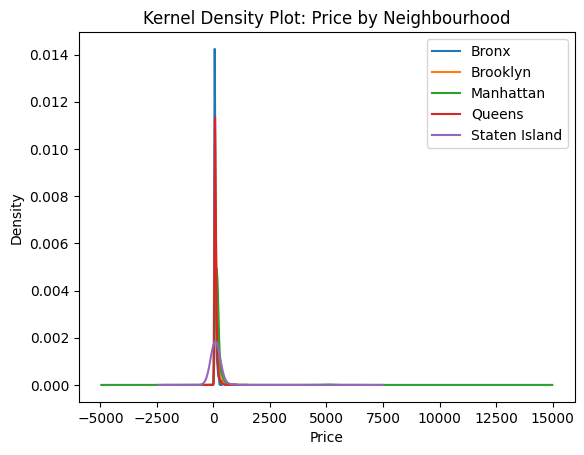

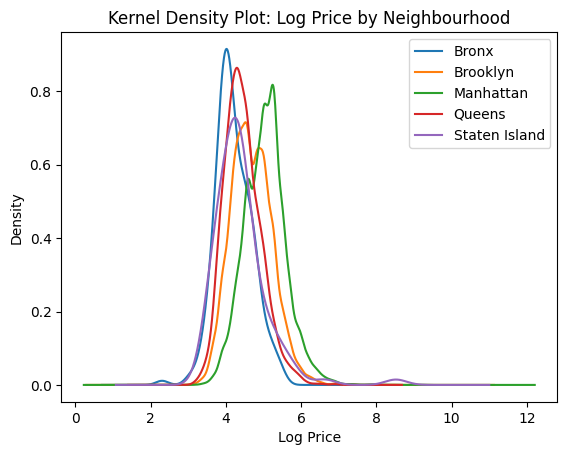

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

url = 'https://raw.githubusercontent.com/ashleynguyen04/linearModels/refs/heads/main/assignment/data/Q1_clean.csv'
df = pd.read_csv(url)

# rename variable
df = df.rename(columns={'Neighbourhood ': 'Neighbourhood'})

grouped = df.groupby('Neighbourhood', as_index=False).agg({
    'Price': 'mean',
    'Review Scores Rating': 'mean'
})

max_price_bou = grouped.loc[grouped['Price'].idxmax(), 'Neighbourhood']
print("Most expensive bourough:", max_price_bou)

# kernel density plot for price
plt.figure()
for name, group in df.groupby('Neighbourhood'):
    group['Price'].plot(kind='kde', label=name)
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Kernel Density Plot: Price by Neighbourhood')
plt.legend()
plt.show()

# kernel density plot for log price
df['Log Price'] = np.log(df['Price'])

plt.figure()
for name, group in df.groupby('Neighbourhood'):
    valid = group['Log Price']
    valid.plot(kind='kde', label=name)
plt.xlabel('Log Price')
plt.ylabel('Density')
plt.title('Kernel Density Plot: Log Price by Neighbourhood')
plt.legend()
plt.show()

2. Regress price on `Neighbourhood ` by creating the appropriate dummy/one-hot-encoded variables, without an intercept in the linear model and using all the data. Compare the coefficients in the regression to the table from part 1. What pattern do you see? What are the coefficients in a regression of a continuous variable on one categorical variable?


In [ ]:
from sklearn.linear_model import LinearRegression

# no intercept dummy
dummy = pd.get_dummies(df['Neighbourhood'], dtype='int')
# dummy.head()

X = dummy
y = df['Price']

model = LinearRegression(fit_intercept=False).fit(X, y)
print(model.coef_)

grouped = df.groupby('Neighbourhood')['Price'].mean()
print(grouped.head())

# The coefficients are the same across both regression calculations and from
# the table in part 1. This means that the coefficients in a regression of a
# continuous variable on one categorical variable are simply the groupwise means

[ 75.2764977  127.74737834 183.66428632  96.8572327  146.16666667]
Neighbourhood
Bronx             75.276498
Brooklyn         127.747378
Manhattan        183.664286
Queens            96.857233
Staten Island    146.166667
Name: Price, dtype: float64


3. Repeat part 2, but leave an intercept in the linear model. How do you have to handle the creation of the dummies differently? What is the intercept? Interpret the coefficients. How can I get the coefficients in part 2 from these new coefficients?


In [ ]:
# intercept dummy
intercept_dummy = pd.get_dummies(df['Neighbourhood'], dtype='int', drop_first=True)
# dummy.head()

int_X = intercept_dummy
y = df['Price']

intercept_model = LinearRegression().fit(int_X, y)
print(intercept_model.coef_)
print(grouped.head())

print(intercept_model.intercept_)

# If you include an intercept, you cannot include all of the dummies. Doing so
# creates perfect multicolinearity, meaning that some coefficients will be
# undefined. To combat this, simply remove one of the dummy columns.

# The intercept in this case is simply the predicted price for the column
# you removed (Bronx, in this case).

# To obtain the other coefficients from part 2, simply add the remaining
# coefficients obtained here to the intercept from the intercept model. For
# example, the next borough is Brooklyn, which has a coefficient of 52.47.
# 52.47 + 75.28 (coeff of Bronx) = 127.75 (coeff of Brooklyn from pt 2).

[ 52.47088065 108.38778863  21.58073501  70.89016897]
Neighbourhood
Bronx             75.276498
Brooklyn         127.747378
Manhattan        183.664286
Queens            96.857233
Staten Island    146.166667
Name: Price, dtype: float64
75.27649769585331


4. Split the sample 80/20 into a training and a test set. Run a regression of `Price` on `Review Scores Rating` and `Neighbourhood `. What is the $R^2$ and RMSE on the test set? What is the coefficient on `Review Scores Rating`? What is the most expensive kind of property you can rent?


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

train_df, test_df = train_test_split(df, test_size=0.2, random_state=31)

train_dummies = pd.get_dummies(train_df["Neighbourhood"], dtype='int', drop_first=True)
test_dummies = pd.get_dummies(test_df["Neighbourhood"], dtype='int', drop_first=True)


X_train = pd.concat([train_df["Review Scores Rating"], train_dummies], axis=1)
y_train = train_df["Price"]


X_test = pd.concat([test_df["Review Scores Rating"], test_dummies], axis=1)
y_test = test_df["Price"]

model = LinearRegression().fit(X_train, y_train)

y_pred = model.predict(X_test)
r2_test = model.score(X_test, y_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))


print("model R^2:", r2_test)
print("model RMSE:", rmse_test)

coef_names = list(X_train.columns)
coefs = list(model.coef_)
coef_df = pd.DataFrame({"Variable": coef_names, "Coefficient": coefs})
print(coef_df)

coef_rating = coef_df.loc[coef_df["Variable"] == "Review Scores Rating", "Coefficient"].values[0]
print("Review Scores Rating coef:", coef_rating)

intercept = model.intercept_
print("Intercept:", intercept)

# The most expensive kind of property you can buy is a Manhattan property, as
# that has the largest value of intercept + coef
# print(model.coef_)

model R^2: 0.07457356922864677
model RMSE: 114.92410578609484
               Variable  Coefficient
0  Review Scores Rating     1.092636
1              Brooklyn    52.468933
2             Manhattan   108.406834
3                Queens    18.860733
4         Staten Island    83.296194
Review Scores Rating coef: 1.0926357256630064
Intercept: -25.032071802745747


5. Split the sample 80/20 into a training and a test set. Run a regression of `Price` on `Review Scores Rating` and `Neighbourhood ` and `Property Type`. What is the $R^2$ and RMSE on the test set? What is the coefficient on `Review Scores Rating`? What is the most expensive kind of property you can rent?


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=31)

train_neigh = pd.get_dummies(train_df["Neighbourhood"], dtype='int', drop_first=True)
test_neigh  = pd.get_dummies(test_df["Neighbourhood"], dtype='int',  drop_first=True)

train_prop = pd.get_dummies(train_df["Property Type"], dtype='int', drop_first=True)
test_prop  = pd.get_dummies(test_df["Property Type"], dtype='int',  drop_first=True)

X_train = pd.concat([
    train_neigh,
    train_prop,
    train_df["Review Scores Rating"]
], axis=1)

X_test = pd.concat([
    test_neigh,
    test_prop,
    test_df["Review Scores Rating"]
], axis=1).reindex(columns=X_train.columns, fill_value=0)

y_train = train_df["Price"]
y_test  = test_df["Price"]

model = LinearRegression().fit(X_train, y_train)

y_pred = model.predict(X_test)
r2_test = model.score(X_test, y_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))


print("pt 5 R^2:", r2_test)
print("pt 5 RMSE:", rmse_test)

intercept = model.intercept_
print("Intercept:", intercept)

coef_names = list(X_train.columns)
coefs = list(model.coef_)
coef_df = pd.DataFrame({"Variable": coef_names, "Coefficient": coefs})
print(coef_df)

coef_rating = coef_df.loc[coef_df["Variable"] == "Review Scores Rating", "Coefficient"].values[0]
print("Review Scores Rating coef:", coef_rating)

# Most expensive kind of property you can rent is a townhouse.

pt 5 R^2: 0.08299507791540628
pt 5 RMSE: 114.39999805826464
Intercept: -37.43208733117052
                Variable  Coefficient
0               Brooklyn    59.103629
1              Manhattan   120.543503
2                 Queens    23.630859
3          Staten Island    75.432353
4        Bed & Breakfast   -28.928714
5                   Boat    58.554793
6               Bungalow    59.051526
7                  Cabin    37.136703
8              Camper/RV   -19.297445
9                 Castle   -40.866564
10           Condominium    89.964102
11                  Dorm   -47.362701
12                 House    34.671173
13                   Hut  -134.401255
14            Lighthouse   -90.426690
15                  Loft    65.155937
16                 Other     4.567624
17             Townhouse    91.307878
18             Treehouse     9.851495
19                 Villa    36.541869
20  Review Scores Rating     1.077551
Review Scores Rating coef: 1.0775514854554729


6. What does the coefficient on `Review Scores Rating` mean if it changes from part 4 to 5? Hint: Think about how multilple linear regression works.


In [ ]:
# It changes because you are controlling Rating across more (and different) variables
# in parts 4 and 5. You are testing directly the contribution of more variables
# to the Review Score Rating. The coefficient decreases from part 4 to 5, and
# this change means that some of the effect attributed to Rating in part 4
# was at least partly due to differences in Property Type.

7. (Optional) We've included `Neighborhood ` and `Property Type` separately in the model. How do you interact them, so you can have "A bedroom in Queens" or "A townhouse in Manhattan". Split the sample 80/20 into a training and a test set and run a regression including that kind of "property type X neighborhood" dummy, plus `Review Scores Rating`. How does the slope coefficient for `Review Scores Rating`, the $R^2$, and the RMSE change? Do they increase significantly compares to part 5? Are the coefficients in this regression just the sum of the coefficients for `Neighbourhood ` and `Property Type` from 5? What is the most expensive kind of property you can rent?

**Q3.** This question is a case study for linear models. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

url = 'https://raw.githubusercontent.com/ashleynguyen04/linearModels/refs/heads/main/assignment/data/cars_hw.csv'
df = pd.read_csv(url)

df["No_of_Owners"] = df["No_of_Owners"].str.replace("st|nd|rd|th", "", regex=True).astype(int)
df.drop_duplicates(inplace=True)
# price presumably includes cents
df["Price"] = df["Price"] / 100

df['Price_ihs'] = np.arcsinh(df['Price'])
df['Mileage_Run_ihs'] = np.arcsinh(df['Mileage_Run'])

print("Shape:", df.shape)
print(df.head())
print(df.info())

Shape: (976, 14)
   Unnamed: 0        Make  Make_Year   Color  Body_Type  Mileage_Run  \
0           1  Volkswagen       2017  silver      sedan        44611   
1           2     Hyundai       2016     red  crossover        20305   
2           3       Honda       2019   white        suv        29540   
3           4     Renault       2017  bronze  hatchback        35680   
4           5     Hyundai       2017  orange  hatchback        25126   

   No_of_Owners  Seating_Capacity Fuel_Type Transmission Transmission_Type  \
0             1                 5    diesel      7-Speed         Automatic   
1             1                 5    petrol      5-Speed            Manual   
2             2                 5    petrol      5-Speed            Manual   
3             1                 5    petrol      5-Speed            Manual   
4             1                 5    petrol      5-Speed            Manual   

    Price  Price_ihs  Mileage_Run_ihs  
0  6570.0   9.483416        11.398883  
1

  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?


Overall Price Summary:
count    976.000000
mean       9.499010
std        0.450276
min        8.232174
25%        9.160624
50%        9.497772
75%        9.779057
max       10.982237
Name: Price_ihs, dtype: float64


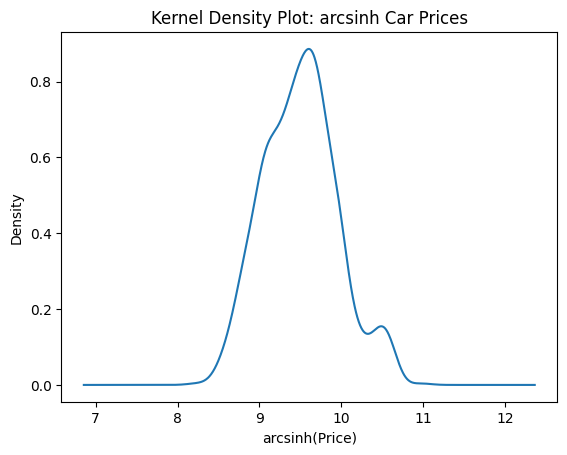

Price Summary by Brand:
               count       mean       std        min        25%        50%  \
Make                                                                         
Chevrolet        6.0   9.007872  0.480975   8.582981   8.656369   8.840263   
Datsun           3.0   8.664024  0.036311   8.626944   8.646279   8.665613   
Ford            52.0   9.556257  0.210895   8.665613   9.449357   9.557470   
Honda           73.0   9.624295  0.336972   8.751475   9.360483   9.661416   
Hyundai        305.0   9.456488  0.398781   8.509161   9.179881   9.454071   
Jeep             4.0  10.304568  0.105084  10.158130  10.271247  10.328242   
Kia              8.0  10.380154  0.076877  10.217568  10.360219  10.391082   
MG Motors       35.0  10.527029  0.066263  10.366592  10.483721  10.517592   
Mahindra        18.0   9.986930  0.159906   9.675331   9.939785   9.993657   
Maruti Suzuki  293.0   9.306109  0.371409   8.463792   9.014326   9.262933   
Nissan           4.0   9.729171  0.39261

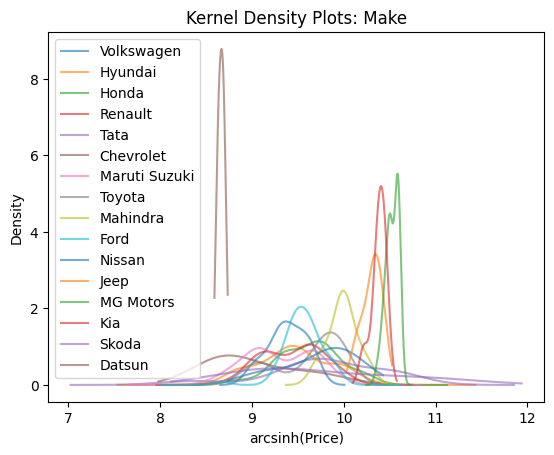

Prices descending: Make
MG Motors        18694.571429
Kia              16147.500000
Jeep             14995.000000
Skoda            11360.000000
Mahindra         11001.666667
Tata             10552.173913
Nissan            8842.500000
Toyota            8003.400000
Honda             7989.726027
Ford              7211.730769
Hyundai           6918.918033
Renault           6625.735294
Volkswagen        6058.275862
Maruti Suzuki     5887.849829
Chevrolet         4535.000000
Datsun            2896.666667
Name: Price, dtype: float64
arcsinh(Prices) descending: Make
MG Motors        10.527029
Kia              10.380154
Jeep             10.304568
Mahindra          9.986930
Tata              9.801382
Nissan            9.729171
Skoda             9.728841
Honda             9.624295
Toyota            9.623484
Ford              9.556257
Hyundai           9.456488
Renault           9.438839
Volkswagen        9.382719
Maruti Suzuki     9.306109
Chevrolet         9.007872
Datsun            8.664024
Nam

In [20]:
p_summary = df["Price_ihs"].describe()
print("Overall Price Summary:")
print(p_summary)

plt.figure()
df["Price_ihs"].plot(kind="density")
plt.title("Kernel Density Plot: arcsinh Car Prices")
plt.xlabel("arcsinh(Price)")
plt.ylabel("Density")
plt.show()

brand_price_summary = df.groupby("Make")["Price_ihs"].describe()
print("Price Summary by Brand:")
print(brand_price_summary)

plt.figure()
for make in df["Make"].unique():
    subset = df[df["Make"] == make]
    subset["Price_ihs"].plot(kind="density", label=make, alpha=0.6)
plt.title("Kernel Density Plots: Make")
plt.xlabel("arcsinh(Price)")
plt.ylabel("Density")
plt.legend()
plt.show()

# most to least expensive
mean_price = df.groupby("Make")["Price"].mean().sort_values(ascending=False)
print("Prices descending:", mean_price)

mean_price = df.groupby("Make")["Price_ihs"].mean().sort_values(ascending=False)
print("arcsinh(Prices) descending:", mean_price)

# MG, Kia, Jeep most expensive - overall mean price in low 5 to high 4 figures.

  3. Split the data into an 80% training set and a 20% testing set.


In [22]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=31)

print("Training Set Shape:", train_df.shape)
print("Testing Set Shape:", test_df.shape)

Training Set Shape: (780, 14)
Testing Set Shape: (196, 14)


  4. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the training set and test set? Make a second model where, for the categorical variables, you regress price on a model comprised of one-hot encoded regressors/features alone (you can use `pd.get_dummies()`; be careful of the dummy variable trap); what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?


In [31]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

numeric_vars = ["Make_Year", "Mileage_Run", "Seating_Capacity"]
categorical_vars = ["Color", "Body_Type", "Make", "Fuel_Type", "Transmission_Type"]

X_train_num = train_df[numeric_vars]
y_train = train_df["Price"]

X_test_num = test_df[numeric_vars]
y_test = test_df["Price"]

model_num = LinearRegression().fit(X_train_num, y_train)

y_train_pred_num = model_num.predict(X_train_num)
y_test_pred_num = model_num.predict(X_test_num)

r2_train_num = r2_score(y_train, y_train_pred_num)
rmse_train_num = np.sqrt(mean_squared_error(y_train, y_train_pred_num))

r2_test_num = r2_score(y_test, y_test_pred_num)
rmse_test_num = np.sqrt(mean_squared_error(y_test, y_test_pred_num))

print("Numeric figures:")
print("Train R^2:", r2_train_num)
print("Train RMSE:", rmse_train_num)
print("Test R^2:", r2_test_num)
print("Test RMSE:", rmse_test_num)
print()

# Categorical
X_train_cat = pd.get_dummies(train_df[categorical_vars], drop_first=True)
X_test_cat = pd.get_dummies(test_df[categorical_vars], drop_first=True)

X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

model_cat = LinearRegression().fit(X_train_cat, y_train)

y_train_pred_cat = model_cat.predict(X_train_cat)
y_test_pred_cat = model_cat.predict(X_test_cat)

r2_train_cat = r2_score(y_train, y_train_pred_cat)
rmse_train_cat = np.sqrt(mean_squared_error(y_train, y_train_pred_cat))

r2_test_cat = r2_score(y_test, y_test_pred_cat)
rmse_test_cat = np.sqrt(mean_squared_error(y_test, y_test_pred_cat))

print("Categorical figures:")
print("Train R^2:", r2_train_cat)
print("Train RMSE:", rmse_train_cat)
print("Test R^2:", r2_test_cat)
print("Test RMSE:", rmse_test_cat)
print("\nCategorical Variables perform better, with a higher R^2 (more variance explained), and a lower RMSE (better Price predictor)\n")

X_train_all = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_all = pd.concat([X_test_num, X_test_cat], axis=1)

model_all = LinearRegression().fit(X_train_all, y_train)

y_train_pred_all = model_all.predict(X_train_all)
y_test_pred_all = model_all.predict(X_test_all)

r2_train_all = r2_score(y_train, y_train_pred_all)
rmse_train_all = np.sqrt(mean_squared_error(y_train, y_train_pred_all))

r2_test_all = r2_score(y_test, y_test_pred_all)
rmse_test_all = np.sqrt(mean_squared_error(y_test, y_test_pred_all))

print("Combined figures:")
print("Train R^2:", r2_train_all)
print("Train RMSE:", rmse_train_all)
print("Test R^2:", r2_test_all)
print("Test RMSE:", rmse_test_all)
print("\nThe combined model performs slightly better than categorical.\n")

Numeric figures:
Train R^2: 0.32164670957033215
Train RMSE: 3143.702101716438
Test R^2: 0.24361263113511467
Test RMSE: 2626.5602171954806

Categorical figures:
Train R^2: 0.7382776452030367
Train RMSE: 1952.6923597799853
Test R^2: 0.61009673944341
Test RMSE: 1885.791446629234

Categorical Variables perform better, with a higher R^2 (more variance explained), and a lower RMSE (better Price predictor)

Combined figures:
Train R^2: 0.843687594250901
Train RMSE: 1509.0726253722203
Test R^2: 0.7671416555219643
Test RMSE: 1457.3408240527417

The combined model performs slightly better than categorical.



  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using in the regression. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 4?


In [38]:
from sklearn.preprocessing import PolynomialFeatures

for i in range(1, 50):
    poly = PolynomialFeatures(degree=i, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_num)
    X_test_poly = poly.transform(X_test_num)

    model_poly = LinearRegression().fit(X_train_poly, y_train)

    y_train_pred = model_poly.predict(X_train_poly)
    y_test_pred = model_poly.predict(X_test_poly)

    r2_train_poly = r2_score(y_train, y_train_pred)
    rmse_train_poly = np.sqrt(mean_squared_error(y_train, y_train_pred))

    r2_test_poly = r2_score(y_test, y_test_pred)
    rmse_test_poly = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print("Figures for", i)
    print("Train R^2:", r2_train_poly)
    print("Train RMSE:", rmse_train_poly)
    print("Test R^2:", r2_test_poly)
    print("Test RMSE:", rmse_test_poly)
    print()

    if r2_test_poly < 0:
      print("Went negative at:", i)
      break

# Degree 1 actually the best based on having the highest R^2 and lowest RMSE,
# and is a good deal worse than our best model, the combined model, from part 4.

Figures for 1
Train R^2: 0.32164670957033215
Train RMSE: 3143.702101716438
Test R^2: 0.24361263113511467
Test RMSE: 2626.5602171954806

Figures for 2
Train R^2: 0.3547777206974826
Train RMSE: 3065.971369023408
Test R^2: 0.23042590230918725
Test RMSE: 2649.3567908066425

Figures for 3
Train R^2: 0.35175085815838725
Train RMSE: 3073.1544869540394
Test R^2: 0.23582602052707013
Test RMSE: 2640.0451298433295

Figures for 4
Train R^2: 0.35975828950844047
Train RMSE: 3054.115095178392
Test R^2: 0.22788330237069088
Test RMSE: 2653.729793756847

Figures for 5
Train R^2: 0.35652831255955586
Train RMSE: 3061.8093071957046
Test R^2: 0.2119129550710842
Test RMSE: 2681.034004131981

Figures for 6
Train R^2: 0.35978525848064546
Train RMSE: 3054.0507700874437
Test R^2: 0.1912479126697888
Test RMSE: 2715.9572852431857

Figures for 7
Train R^2: 0.18280866986692568
Train RMSE: 3450.44645791833
Test R^2: 0.051027800432837944
Test RMSE: 2941.995289283663

Figures for 8
Train R^2: 0.14366423593168254
Train 

  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

**Q4.** This question refers to the `heart_hw.csv` data. It contains three variables:

  - `y`: Whether the individual survived for three years, coded 0 for death and 1 for survival
  - `age`: Patient's age
  - `transplant`: `control` for not receiving a transplant and `treatment` for receiving a transplant

Since a heart transplant is a dangerous operation and even people who successfully get heart transplants might suffer later complications, we want to look at whether a group of transplant recipients tends to survive longer than a comparison group who does not get the procedure.

1. Compute (a) the proportion of people who survive in the control group who do not receive a transplant, and (b) the difference between the proportion of people who survive in the treatment group and the proportion of people who survive in the control group. In a randomized controlled trial, this is called the **average treatment effect**.
2. Regress `y` on `transplant` using a linear model with a constant. How does the constant/intercept of the regression and the coefficient on transplant compare to your answers from part 1? Explain the relationship clearly.
3. We'd like to include `age` in the regression, since it's reasonable to expect that older patients are less likely to survive an extensive surgery like a heart transplant. Regress `y` on a constant, transplant, and age. How does the intercept change?
4. Build a more flexible model that allows for non-linear age effects and interactions between age and treatment. Use a train-test split to validate your model. Estimate your best model, predict the survival probability by age, and plot your results conditional on receiving a transplant and not. Describe what you see.
5. Imagine someone suggests using these kinds of models to select who receives organ transplants; perhaps the CDC or NIH starts using a scoring algorithm to decide who is contacted about a potential organ. What are your concerns about how it is built and how it is deployed?

**Q5.** This is a question about linear regression. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running the following regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q6.** Let's explore multiple linear regression in a two-variable case, to build more intuition about what is happening.

Suppose the model is
$$
\hat{y}_i = b_0 + b_1 z_{i1} + b_2 z_{i2}
$$
Assume that $z_{ij}$ is centered or de-meaned, so that $z_{ij} = x_{ij} - m_j$ where $m_j$ is the mean of variable $j$ and $x_{ij}$ is the original value of variable $j$ for observation $i$. Notice that this implies
$$
\dfrac{1}{N} \sum_{i=1}^N z_{ij} = 0
$$
which will simplify your calculations below substantially!

1. Write down the SSE for this model.
2. Take partial derivatives with respect to $b_0$, $b_1$, and $b_2$.
3. Verify that the average error is zero and $e \cdot z =0$ at the optimum, just as in the single linear regression case.
4. Show that the optimal intercept is $b_0^* = \bar{y}$. Eliminate $b_0^*$ from the remaining equations, and focus on $b_1$ and $b_2$.
5. Write your results as a matrix equation in the form "$Ab=C$". These are called the **normal equations**.
6. Divide both sides by $N$ and substitute $z_{ij} = x_{ij} - m_j$ back into your normal equations for $x_{ij}$. What is the matrix $A$? What is the vector $C$? Explain the intuition of your discovery.

**Q7.** In class, we showed that for the single linear regression model,
\begin{alignat*}{3}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{alignat*}

1. When will $b^*$ be large or small, depending on the relationship between $X$ and $Y$ and the variance of $X$?
2. Suppose you have measurement error in $X$ which artificially inflates its variance (e.g. bad data cleaning). We'll model this as saying the "real" value of $X$ for observation $i$ is $z_i$, but we observe $x_i = z_i + n_i$, where $n_i$ is the added noise. Does this affect the intercept of the regression? What happens to the $b^*$ coefficient relative to a noise-less model? How will affect your ability to predict? (This phenomenon is called **attenuation**.)
3. Suppose the noise $n_i$ is independent of $z_i$ and $y_i$, so that (approximately)
$$
\dfrac{1}{N} \sum_{i=1}^N (y_i - \bar{y})(n_i - \bar{n}) =0, \quad \dfrac{1}{N} \sum_{i=1}^N (z_i - \bar{z})(n_i - \bar{n}) =0.
$$
and that the mean of the bias is zero, so that
$$
\dfrac{1}{N} \sum_{i=1}^N n_i = 0.
$$
In this case, the noise $n_i$ is zero on average and independent of the values of $x_i$ and $y_i$: It's just measurement error or lazy data cleaning.
Explain the intuition of your result.

4. How does attenuation factor into the cost-benefit analysis of gathering higher quality data or cleaning it more carefully?

**Q8.**
1. Find a dataset on a topic you're interested in. Some easy options are data.gov, kaggle.com, and data.world.
2. Clean the data and do some exploratory data analysis on key variables that interest you. Pick a particular target/outcome variable and features/predictors.
3. Split the sample into an ~80% training set and a ~20% test set.
4. Run a few regressions of your target/outcome variable on a variety of features/predictors. Compute the SSE on the test set.
5. Which model performed the best, and why?
6. What did you learn?

**Q9.** There is a folder called `heart_failure` which contains reasonably detailed health data on patients and whether they die of congestive heart failure.

1. Load the data and perform an 80/20-train/test split.
2. Using dummy/one-hot-encoded variables and transformations of the numeric features, build the best model you can. **But**, do not delete code chunks or revise your work substantially as you experiment. Just keep moving forward with your ideas and experiments.
3. When you're done, scroll through your notebook. What worked and what didn't? Does your code have intention, or are you randomly experimenting? If you had to do this again, what might you do differently to get to a good model faster?


**Q10.** Let's look at a cousin of Linear Regression, called **kernel regression** or **local constant least squares** or **Nadaraya-Watson Estimator**.

We derived the OLS estimator for single linear regression by minimizing
$$
SSE(b_0, b_1) = \frac{1}{N}\sum_{i=1}^N (y_i - b_0 - b_1 x_i)^2
$$
with solution
$$
\hat{b}_0 = \bar{y} - \hat{b}_1 \bar{x}, \quad \hat{b}_1 = \dfrac{\frac{1}{N} \sum_{i=1}^N (x_i-\bar{x})(y_i - \bar{y})}{s_x^2}.
$$

When you step back and think about it, this is a bit weird: The algorithm is computing sample means, variances, and covariances, and using those to create a predictive model. The data themselves arguably vanish from the solution. This is elegant, this is strange.

Instead, let $k(z)$ be a kernel function, such as the Gaussian
$$
k(z) = \frac{1}{\sqrt{2\pi}} e^{-z^2/2}
$$
or uniform
$$
k(z) = \begin{cases}
1/2, & |z| \le \frac{1}{2}\\
0, & \text{otherwise.}
\end{cases}
$$
We'll instead minimize, or each predictor value $x$,
$$
SSE(\hat{y}(x)) = \dfrac{1}{N} \sum_{i=1}^N \left\lbrace y_i - \hat{y}(x)\right\rbrace^2 \dfrac{1}{h} k \left( \dfrac{x-x_i}{h} \right).
$$

1. Show that the optimal predictor is
$$
\hat{y}(x) = \dfrac{ \frac{1}{Nh} \sum_{i=1}^N  y_i k \left( \dfrac{x-x_i}{h} \right) }{\frac{1}{Nh} \sum_{i=1}^N k \left(  \dfrac{x-x_i}{h} \right)}
$$
This has many names, but let's call it the local constant least squares (LCLS) estimator, as opposed to ordinary least squares (OLS).

2. Compare and contrast LCLS with both OLS and $k$-Nearest Neighbor as a regression algorithm.

3. Write a function or class that implements the LCLS estimator for a single predictor variable $x$. For a default bandwidth $h$, you can use the maximum of the Silverman plug-ins for estimating kernel densities for $X$ and $Y$:
$$
h_y = 1.06 \times s_y^{-1/5}, \quad h_x = 1.06 \times s_x^{-1/5},
$$
$$
h = \max \{ h_y, h_x \}.
$$
For the kernel, you can hard-code the uniform, Gaussian, or Epanechnikov, or make it a parameter the user can adjust with a default choice.

4. For one of the datasets available for the homework, use your LCLS estimator from part 3 to predict values $\hat{y}(x_i)$ for each datapoint $x_i$. Plot your estimator $\hat{y}$ as a line over a scatterplot of the data $\{(x_i,y_i)\}_{i=1}^N$. Tune the bandwidth until you

5. Conceptually, how would you extend this analysis to a vector of predictors, $x = (x_1, ..., x_L)$ instead of just one explanatory variable $x$?
